# Dataset processing

This notebook processes entries from the Swissprot database into datasets for our models. It assumes the Swissprot database has been downloaded in text format from https://www.uniprot.org/downloads and decompressed and saved to the `seqDirPath` directory defined below (the filename should then be `seqDirPath/'uniprot_sprot.dat'`).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Import libraries:

In [2]:
from fastai import *
from fastai.text import *

import pickle

sys.path.append("..")
import readseq

seqDirPath = Config().data_path()/'pseq'

### Set up protein filtering:

In [3]:
# Path to Swissprot database in flat file format:
datFPath = seqDirPath/'uniprot_sprot.dat'

# Filter proteins to those with only the 20 common amino acids,
# between 40 and 500 aa in length, with evidence level <= 3,
# not flagged as a fragment:
lmAllPFilterPars = dict(
    restrictTo20AA = True,
    minLen = 40,
    maxLen = 500,
    maxPE = 3,
    requireInName='',
    excludeStrs = ['fragment'],
)

# Same as above, but restricting to proteins not flagged as transmembrane:
lmFilterPars = dict(lmAllPFilterPars,elimKWs=['transmembrane'])

# Same as above, but restricting to proteins flagged as transmembrane:
lmTMFilterPars = dict(lmAllPFilterPars,requireKWs=['transmembrane'])

clusterLen = 30

Check to make sure we're catching all transmembrane proteins:

In [4]:
pKws = readseq.scanDat(datFPath,readseq.getDatKWs)
for i in [0,1,2,55] :
    print('Protein',i,'keywords:',pKws[i])
(len([kwList for kwList in pKws if 'transmembrane' in kwList]),
 len([kwList for kwList in pKws if any('transmembrane' in kw.lower() for kw in kwList)]))

Protein 0 keywords: ('activator', 'complete proteome', 'reference proteome', 'transcription', 'transcription regulation')
Protein 1 keywords: ('complete proteome', 'host membrane', 'membrane', 'reference proteome', 'transmembrane', 'transmembrane helix')
Protein 2 keywords: ('complete proteome', 'reference proteome')
Protein 55 keywords: ('coiled coil', 'complete proteome', 'reference proteome')


(78965, 78965)

Check some stats on our data:

In [5]:
print(); print('All organisms, all PE, not transmembrane:')
readseq.makeLMDataset(datFPath,lmFilterPars,maxPE=5);
print(); print('All organisms, PE<=3, not transmembrane:')
readseq.makeLMDataset(datFPath,lmFilterPars);
print(); print('All organisms, PE<=3, all:')
seqM = readseq.makeLMDataset(datFPath,lmAllPFilterPars);
print(); print('All organisms, PE<=3, transmembrane:')
readseq.makeLMDataset(datFPath,lmTMFilterPars);
print(); print('Human, PE<=3, not transmembrane:')
readseq.makeLMDataset(datFPath,lmFilterPars,requireInSpecies='homo sapiens');


All organisms, all PE, not transmembrane:
total length 97,318,324 in 382,034 sequences; 20 letters: ACDEFGHIKLMNPQRSTVWY

All organisms, PE<=3, not transmembrane:
total length 95,228,956 in 371,144 sequences; 20 letters: ACDEFGHIKLMNPQRSTVWY

All organisms, PE<=3, all:
total length 109,566,507 in 423,741 sequences; 20 letters: ACDEFGHIKLMNPQRSTVWY

All organisms, PE<=3, transmembrane:
total length 14,337,551 in 52,597 sequences; 20 letters: ACDEFGHIKLMNPQRSTVWY

Human, PE<=3, not transmembrane:
total length 2,395,489 in 8,492 sequences; 20 letters: ACDEFGHIKLMNPQRSTVWY


### A quick look at amino acid frequencies over our main dataset.

I found it surprising that the distribution looks so linear!

In [6]:
aaFreqs = sorted(readseq.cCounts(seqM.values()).items(), key=lambda x:x[1])
print('Amino acid frequencies:')
for aaLet,freq in aaFreqs :
    print('{}: {:,}'.format(aaLet,freq))

Amino acid frequencies:
W: 1,163,456
C: 1,458,227
H: 2,479,822
M: 2,776,509
Y: 3,153,119
Q: 4,071,354
N: 4,194,148
F: 4,233,221
P: 4,950,437
T: 5,750,239
D: 5,915,042
R: 6,169,590
K: 6,347,938
S: 6,645,509
I: 6,729,662
E: 7,217,450
V: 7,846,126
G: 8,132,890
A: 9,649,981
L: 10,681,787


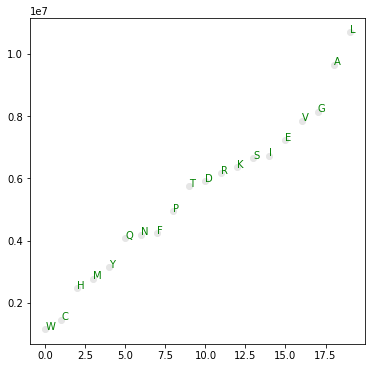

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(range(len(aaFreqs)), [freq for _,freq in aaFreqs], color=(0.9,0.9,0.9))
for i,(aaLet,freq) in enumerate(aaFreqs) :
    plt.text(i,freq,aaLet,color='green')
plt.show()

### Generate datasets for language models:

In [8]:
lmDatasetList = [
    ('swissprotPE3AA20AllP','all organisms, PE<=3, all',lmAllPFilterPars),
    ('swissprotPE3AA20NoTM','all organisms, PE<=3, not transmembrane',lmFilterPars),
    ('swissprotPE3AA20TM','all organisms, PE<=3, transmembrane',lmTMFilterPars),
]
for lmFName,desc,pars in lmDatasetList :
    print(); print('Generating dataset',lmFName,'-',desc+':')
    readseq.makeLMDataset(datFPath,pars,seqDirPath/(lmFName+'.csv'),
                          seqDirPath/(lmFName+'clusters.csv'),clusterLen)


Generating dataset swissprotPE3AA20AllP - all organisms, PE<=3, all:
total length 109,566,507 in 423,741 sequences; 20 letters: ACDEFGHIKLMNPQRSTVWY
length-30 subsequences: total 97,278,018, unique 65,180,353
181,009 clusters; identifier counts: 423,741, 423,741

Generating dataset swissprotPE3AA20NoTM - all organisms, PE<=3, not transmembrane:
total length 95,228,956 in 371,144 sequences; 20 letters: ACDEFGHIKLMNPQRSTVWY
length-30 subsequences: total 84,465,780, unique 56,316,364
157,248 clusters; identifier counts: 371,144, 371,144

Generating dataset swissprotPE3AA20TM - all organisms, PE<=3, transmembrane:
total length 14,337,551 in 52,597 sequences; 20 letters: ACDEFGHIKLMNPQRSTVWY
length-30 subsequences: total 12,812,238, unique 8,873,011
23,861 clusters; identifier counts: 52,597, 52,597


### Generate datasets for classification:

In [9]:
def makeClasDataset(lmFName,dsName,propFn,propKwArgs={},**kwargs) :
    fullDsName = lmFName+'_'+dsName
    print('Generating',fullDsName,'dataset:')
    readseq.makeClasDataset(datFPath,seqDirPath/(lmFName+'clusters.csv'),
                            propFn,propKwArgs,
                            seqDirPath/(fullDsName+'Train.csv'),
                            seqDirPath/(fullDsName+'Test.csv'),
                            **kwargs)

for dsName,fn,nCopies in [
        ('atpBind',readseq.getDatAtpBinding,1),
        ('gtpBind',readseq.getDatGtpBinding,10),
        ('metalBind',readseq.getDatMetalBinding,3),
    ] :
    print(); print('Overall frequencies for',dsName+':',readseq.countDat(datFPath,fn))
    for lmFName,_,_ in lmDatasetList :
        makeClasDataset(lmFName,dsName,fn,nCopiesFn=readseq.dupPos(nCopies))


Overall frequencies for atpBind: Counter({'neg': 473231, 'pos': 88125})
Generating swissprotPE3AA20AllP_atpBind dataset:
train: 318857 valid: 27251 test: 17871 skipped: 59762 clusters: 181009
Generating swissprotPE3AA20NoTM_atpBind dataset:
train: 278510 valid: 23728 test: 15558 skipped: 53348 clusters: 157248
Generating swissprotPE3AA20TM_atpBind dataset:
train: 39320 valid: 3648 test: 2422 skipped: 7207 clusters: 23861

Overall frequencies for gtpBind: Counter({'neg': 546803, 'pos': 14553})
Generating swissprotPE3AA20AllP_gtpBind dataset:
train: 318857 valid: 27251 test: 17871 skipped: 59762 clusters: 181009
Generating swissprotPE3AA20NoTM_gtpBind dataset:
train: 278510 valid: 23728 test: 15558 skipped: 53348 clusters: 157248
Generating swissprotPE3AA20TM_gtpBind dataset:
train: 39320 valid: 3648 test: 2422 skipped: 7207 clusters: 23861

Overall frequencies for metalBind: Counter({'neg': 505764, 'pos': 55592})
Generating swissprotPE3AA20AllP_metalBind dataset:
train: 318857 valid: 2